In [1]:
import networkx as nx
#import pylab as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from timeit import default_timer as timer
from matplotlib.pyplot import figure
import statistics


In [2]:
PR_df = pd.read_csv('./PR_df.csv')
PR_df.sort_values(by='0',inplace = True, ascending=False)
PR_df.reset_index(drop = True, inplace = True)
PR_df.rename(columns={'Unnamed: 0':'Author', '0':'PR_values'}, inplace = True)
PR_df

,Author,PR_values
0,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.042414
1,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.015953
2,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014931
3,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014887
4,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.014411
...,...,...
873,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.000483
874,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.000483
875,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.000483
876,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,0.000483


In [3]:
DB_AA_originale = pd.read_csv('./DB_articles_authors_built.csv')


#genesis_tx_node_id = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']=='Not_available']['ToNodeId'].values[0]
#RIMUOVO LE CITAZIONI INIZIALI FATTE VERSO LA GENESIS TX DAGLI ARTICOLI DI FRONTIERA
#DB_AA_originale = DB_AA_originale[DB_AA_originale['ToNodeId']!= genesis_tx_node_id]
DB_AA_originale.head()

,FromNodeId,From_Author_Pub_Key,ToNodeId,To_Author_Pub_key
0,6fa885a34dedefccbe0dfa66a25bea75f8582c16961bc8...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,9eeac919ecf6143c012aea787e2941e15e61919722d761...,Not_available
1,a41f0364419573ad34dcb7fa3a430377289da6c611332b...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,9eeac919ecf6143c012aea787e2941e15e61919722d761...,Not_available
2,d7c46633d0e08d81d0140b8b2e21eaf04e4ff0a646ed54...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,9eeac919ecf6143c012aea787e2941e15e61919722d761...,Not_available
3,f6875f955a15bea705608ddf89a11e4dec6adee164d9e8...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,a41f0364419573ad34dcb7fa3a430377289da6c611332b...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...
4,ee468adc9cfa812d0cf7530ec5a69d2ed61fc7adeaa456...,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,9eeac919ecf6143c012aea787e2941e15e61919722d761...,Not_available


In [4]:
DB_AA_originale.FromNodeId.nunique()

1066

In [5]:
DB_AA_originale.From_Author_Pub_Key.nunique()

878

In [6]:
#load the msg_DB from file 
def readMsgDB():
    print('Checking for local message_id stored...\n')
    try: 
        file = open("lista_msgDB.txt", "r")
        msg_DB = file.readlines()

        for i in range(len(msg_DB)):
            msg_DB[i] = msg_DB[i].replace("\n", "")

        print(f'Found #{len(msg_DB)} messages from the file lista_msgDB.txt \n')

        file.close() 
    except:
        
        msg_DB = []

    
    return msg_DB

msg_DB = readMsgDB()

Checking for local message_id stored...

Found #1066 messages from the file lista_msgDB.txt 



In [7]:
#load the DF containing the communities found
Communities = pd.read_csv('./Best_Clusters_DF.csv')
Communities.sort_values(by='cluster_size',inplace = True)

Communities.reset_index(drop = True, inplace = True)

def replaceSlash(row):
    return row.replace('\\n','\n')

repS = np.vectorize(replaceSlash)

Communities.cluster_authors = repS(Communities.cluster_authors)

Communities

,cluster_authors,cluster_size
0,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
1,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
2,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
3,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
4,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
...,...,...
73,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,35
74,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,45
75,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,50
76,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,82


In [8]:
Communities.cluster_size.sum()

878

In [9]:
Communities[Communities['cluster_size']==1]

,cluster_authors,cluster_size
0,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
1,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
2,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
3,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
4,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
5,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1
6,-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w...,1


In [9]:
#Communities.index.values

In [10]:
#Costruisco grafo avente tanti nodi quante communities. Ogni arco a->b esiste <=> la community a contiene un 
#autore che cita un autore contenuto nella community b

num_nodi = len(Communities)


#GRAPH CREATION


#STAMPA GRAFO
D=nx.DiGraph()

for i in Communities.index.values:
    D.add_node(str(i),nodeId = str(i))
    
for i in Communities.index.values: 
    
    inner_authors = Communities.iloc[i]['cluster_authors'].split("*")
    
    for j in Communities.index.values:
        
        if(i!=j):
        
            outer_authors = Communities.iloc[j]['cluster_authors'].split("*")

            temp_df = DB_AA_originale[DB_AA_originale['From_Author_Pub_Key'].isin(inner_authors)]

            temp_df = temp_df[temp_df['To_Author_Pub_key'].isin(outer_authors)]

            #print(temp_df)

            if(len(temp_df) > 0):           

                D.add_weighted_edges_from([(str(i),str(j),len(temp_df))])


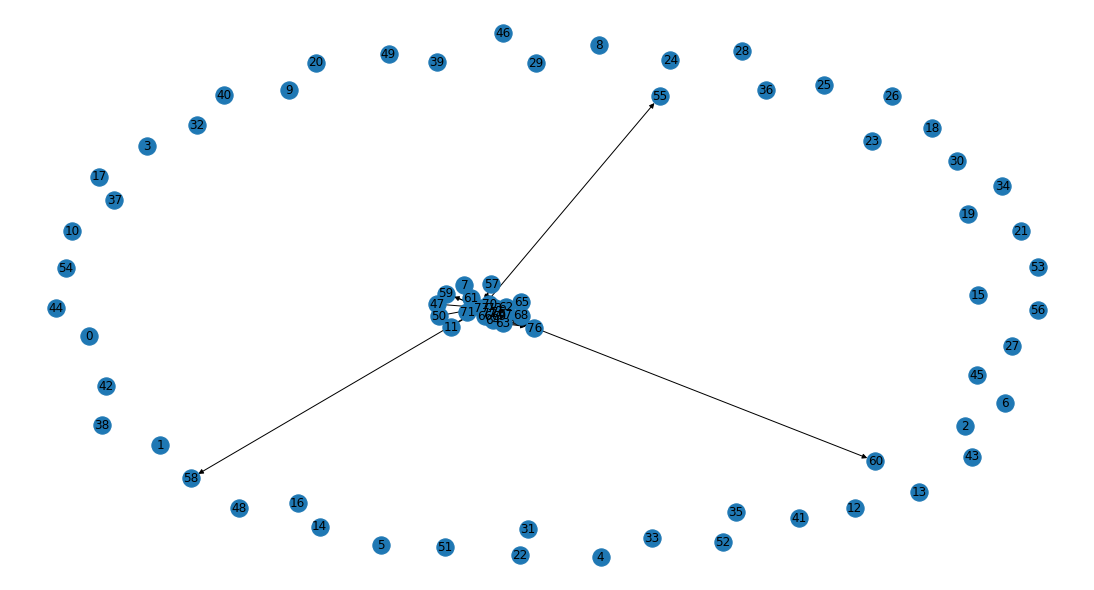

In [11]:
figure(figsize=(15,8))

nx.draw(D, with_labels=True)
plt.show()

In [12]:
#Poiche il dataset Communities ha, in ogni riga, gli autori separati dal carattere '*', 
#per rendere efficiente il calcolo in seguito, vengono splittati ora
Communities_splitted = pd.DataFrame(columns=['community','authors'])
Communities_splitted.community = range(0,len(Communities))
Communities_splitted.set_index('community',inplace = True)

lun = 0

for i in range(len(Communities)):
    autori = Communities.loc[i]['cluster_authors'].split("*")
    Communities_splitted.loc[i]['authors'] = autori
    lun += len(autori)
    
print(lun)
    


878


In [13]:
Communities_splitted

,authors
community,
0,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
1,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
2,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
3,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
4,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
...,...
73,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
74,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...
75,[-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9...


In [17]:
#Nelle due celle seguenti viene mostrata la differenza tra i due DF

In [14]:
Communities.iloc[-1]['cluster_authors']

'-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzYWMcfx5jSTIH8D6G8mJ\nQPFkDQNFneySj5NnaRtyHeIBv4INmbW6upgnr7d1FUTlI7bKAq8zQeDqzNW0/eX7\nfFLovpWSqOmQBi5udYqyIyfK8eoONZBCM9B+gXzDX7nD0e27a5xfqMGAgKRE+lmL\nj6vf7Hf1uiD2OmonULKNuGbfCWD/XR8ERCbt/lDwm6K/EG9L1nbniK3PPl3qdq/Y\nXq7+d164dm3C6HZSz5CEslUbo0C1M8c5DrdtXJJW6NUGFh2G/6lXp8+O1yRzTVvy\ng5+AZrQhDhTR+1XZagl0kePvNBd9VSGm9evRodCWOM4fD81oMqvwHRhEDQZiWj6Q\nMQIDAQAB\n-----END PUBLIC KEY-----\n*-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzMTu4ckscA29K63hfgc8\nGXGaxtprbsOO87xNW1L2OZvpXJkP11szgVRS8X7pJq/TCROnvEqpWVYTYnpZ7JLt\nBhDv7bRA2uZCS1/9yDmwSjaiK83/2DarUCN+BzE5reXeWhTArtx0TjMsUcEFBFXT\nxmOfFuX6qT8gW4SpH0OvSN78212Yup38RMMrL3w87m7Cbg4w40yDzU5vvv6n6Lsm\nHUiPBtRa9zAAnImyW7LeICpGAejF3/xRAWPzrpZRieW1S0judC8eYeE6pRPBGTS2\noo+W/3gmgp8CxOvnroxSfz8qcNJyDQq6vEG/XWugGOg6p0ZPtwVjHck4fK6ZyNv/\n7wIDAQAB\n-----END PUBLIC KEY-----\n*-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAyithp

In [15]:
Communities_splitted.iloc[-1]['authors']

['-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzYWMcfx5jSTIH8D6G8mJ\nQPFkDQNFneySj5NnaRtyHeIBv4INmbW6upgnr7d1FUTlI7bKAq8zQeDqzNW0/eX7\nfFLovpWSqOmQBi5udYqyIyfK8eoONZBCM9B+gXzDX7nD0e27a5xfqMGAgKRE+lmL\nj6vf7Hf1uiD2OmonULKNuGbfCWD/XR8ERCbt/lDwm6K/EG9L1nbniK3PPl3qdq/Y\nXq7+d164dm3C6HZSz5CEslUbo0C1M8c5DrdtXJJW6NUGFh2G/6lXp8+O1yRzTVvy\ng5+AZrQhDhTR+1XZagl0kePvNBd9VSGm9evRodCWOM4fD81oMqvwHRhEDQZiWj6Q\nMQIDAQAB\n-----END PUBLIC KEY-----\n',
 '-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKCAQEAzMTu4ckscA29K63hfgc8\nGXGaxtprbsOO87xNW1L2OZvpXJkP11szgVRS8X7pJq/TCROnvEqpWVYTYnpZ7JLt\nBhDv7bRA2uZCS1/9yDmwSjaiK83/2DarUCN+BzE5reXeWhTArtx0TjMsUcEFBFXT\nxmOfFuX6qT8gW4SpH0OvSN78212Yup38RMMrL3w87m7Cbg4w40yDzU5vvv6n6Lsm\nHUiPBtRa9zAAnImyW7LeICpGAejF3/xRAWPzrpZRieW1S0judC8eYeE6pRPBGTS2\noo+W/3gmgp8CxOvnroxSfz8qcNJyDQq6vEG/XWugGOg6p0ZPtwVjHck4fK6ZyNv/\n7wIDAQAB\n-----END PUBLIC KEY-----\n',
 '-----BEGIN PUBLIC KEY-----\nMIIBIjANBgkqhkiG9w0BAQEFAAOCAQ8AMIIBCgKC

In [16]:
#Creo il DF che conterrà la stima di veridicità calcolata per ogni articolo

stima_veridicita_articoli = pd.DataFrame(columns=['article_id','estimate'])
stima_veridicita_articoli['article_id'] = msg_DB
stima_veridicita_articoli.set_index('article_id',inplace = True)
stima_veridicita_articoli

,estimate
article_id,
6fa885a34dedefccbe0dfa66a25bea75f8582c16961bc8a2740faa76d2bd3b0f,NaN
a41f0364419573ad34dcb7fa3a430377289da6c611332b9d8aeedc211df83197,NaN
d7c46633d0e08d81d0140b8b2e21eaf04e4ff0a646ed542985ded463fbd51479,NaN
f6875f955a15bea705608ddf89a11e4dec6adee164d9e8054feb251774910bff,NaN
ee468adc9cfa812d0cf7530ec5a69d2ed61fc7adeaa4561729afe48acc6f0466,NaN
...,...
a1f93dbb0c77e3c1b824e8aaac13b787a2017b02b1b63f88af421fd283e4717a,NaN
120953ee2720e5768e3e2075c0829a627822b7ec670169b2d014efb5650499fe,NaN
0f1ee6366fd5c88645e03c53bbfdf8db5601b6632e148cee28047a741f59c45f,NaN


a[PR(auth_i)/PR_Max] + b[#cit_entranti_i/#cit_entranti_Max] + c[AVG(PR_auth_citano_i)/PR_Max] + d[Communities value]

In [17]:
#TEST FATTO IGNORANDO I WEIGHT TRA LE COMMUNITIES, CONSIDERO SOLO I #HOP


#Definisco i valori comuni necessari al calcolo

#PR normalization---
PR_Max = PR_df.query('PR_values == PR_values.max()')['PR_values'].values[0]
PR_Min = PR_df.query('PR_values == PR_values.min()')['PR_values'].values[0]
PR_Difference = PR_Max - PR_Min
PR_mean = PR_df.PR_values.mean()
PR_stdev = PR_df.PR_values.std()
print(PR_Min)

#max_cit_entranti---
genesis_tx_node_id = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']=='Not_available']['ToNodeId'].values[0]
#RIMUOVO LE CITAZIONI INIZIALI FATTE VERSO LA GENESIS TX DAGLI ARTICOLI DI FRONTIERA
DB_AA_originale_senza_genesis = DB_AA_originale[DB_AA_originale['ToNodeId']!= genesis_tx_node_id]
res = DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count()
cit_entranti_max = res.max()
cit_entranti_min = res.min()
cit_entranti_Difference = cit_entranti_max - cit_entranti_min
cit_entranti_mean = DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count().mean()
cit_entranti_stdev =DB_AA_originale_senza_genesis.groupby('To_Author_Pub_key')['From_Author_Pub_Key'].count().std()
print(cit_entranti_min)

#max_len_#_hop---
path = dict(nx.all_pairs_dijkstra_path(D))
list_of_len = []
max_len = 0
min_len = len(D.nodes)
for node in D.nodes: #per ogni nodo
    for paths in path[node]: #per ogni nodo raggiungibile da tale nodo
        if(paths != node):
            local_len = len(path[node][paths])-1
            list_of_len.append(local_len)
            if(local_len > max_len):
                max_len = local_len
            elif(local_len < min_len):
                min_len = local_len

print(max_len)
print(min_len)
len_Difference = max_len - min_len
print(len_Difference)
mean_len = statistics.mean(list_of_len)
stdev_len = statistics.stdev(list_of_len)



0.0004834505536795
1
5
1
4


In [18]:
#Fornito in input un set di ids delle communities che citano un articolo & community autore articolo citato
#Per ogni community, calcola la distanza media tra di essa e tutte le altre.
#Poi viene restituita la distanza media minore.

#viene invocata solo se il numero di communities coinvolte è > 1 => l'articolo è citato da almeno una community diversa da quella del suo autore

def computeMinOfHopAvgDist(communities_coinvolte):
    
    min_avg_dist = max_len #init la distanza minore individuata finora al valore della distanza max
    
    #print(f'COMP, comm_coinvolte: {communities_coinvolte}')
    
    for i in communities_coinvolte: #per ogni community citante
        
        #print(f'I: {i}')
        
        local_avg_dist = 0

        for j in communities_coinvolte: #scandisco le altre communities citanti
            #print(f'J: {j}')
            if(i!=j):
                if(str(j) in path[str(i)]):
                    local_avg_dist += len(path[str(i)][str(j)])-1 #se esiste path tra loro, prendo il num di hop
                    #print(f'LAD1: {local_avg_dist}')
                else:
                    local_avg_dist += max_len #se non esiste path tra loro, assumo #hop massimo nel grafo PERCHE maggiore è la distanza e maggiore è il punteggio assegnato
                    #print(f'LAD2: {local_avg_dist}')
                    
        local_avg_dist = local_avg_dist/(len(communities_coinvolte)-1) #calcolo media distanza tra la community e le altre (che in numero sono len(communities_coinvolte)-1)
            
        #print(f'LAD3: {local_avg_dist}')
            
            
        if(local_avg_dist > 0 and local_avg_dist < min_avg_dist):
            min_avg_dist = local_avg_dist

    return min_avg_dist


In [19]:
#Fornito in input un set di ids delle communities che citano un articolo & community autore articolo citato
#Per ogni community, calcola la distanza media tra di essa e tutte le altre.
#Poi viene restituita la distanza media minore.

#viene invocata solo se il numero di communities coinvolte è > 1 => l'articolo è citato da almeno una community diversa da quella del suo autore

def computeAvgOfHopAvgDist(communities_coinvolte):
    

    avg_dist = 0 #init la distanza media
    
    #print(f'COMP, comm_coinvolte: {communities_coinvolte}')
    
    for i in communities_coinvolte: #per ogni community citante
        
        #print(f'I: {i}')
        
        local_avg_dist = 0

        for j in communities_coinvolte: #scandisco le altre communities citanti
            #print(f'J: {j}')
            if(i!=j):
                if(str(j) in path[str(i)]):
                    local_avg_dist += len(path[str(i)][str(j)])-1 #se esiste path tra loro, prendo il num di hop
                    #print(f'LAD1: {local_avg_dist}')
                else:
                    local_avg_dist += max_len #se non esiste path tra loro, assumo #hop massimo nel grafo PERCHE maggiore è la distanza e maggiore è il punteggio assegnato
                    #print(f'LAD2: {local_avg_dist}')
                    
        local_avg_dist = local_avg_dist/(len(communities_coinvolte)-1) #calcolo media distanza tra la community e le altre (che in numero sono len(communities_coinvolte)-1)
            
        #print(f'LAD3: {local_avg_dist}')
            
            
        avg_dist += local_avg_dist

    return avg_dist/len(communities_coinvolte)


# NORMALIZZAZIONE FATTA DIVIDENDO PER MAX_VALUE

<AxesSubplot:xlabel='article_id'>

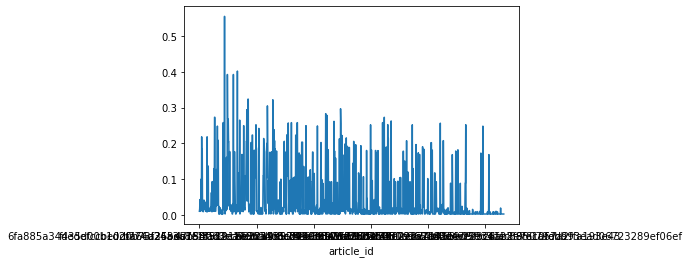

In [20]:

#MIN OF AVG

stima = []

autori_radiati =[]

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    
    if(num_cit_entranti > 0):
    
        autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values


        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()

        #print(autori_citanti)

        #calcolo la distanza tra le communities che mi citano 
        
        
        communities_coinvolte = []
        
        autori_coinvolti = autori_citanti 
        autori_coinvolti = np.append(autori_coinvolti,autore)
        
        #in questo modo insierisco anche la community dell'autore dell'articolo 
        #=> calcolo la distanza media tra tutte le communities coinvolte, quelle dell'autore citato e citante 

        for i in autori_coinvolti:
            for j in range(len(Communities_splitted)):
                if(i in Communities_splitted.loc[j]['authors'] ):
                    communities_coinvolte.append(j)

        communities_coinvolte = np.unique(communities_coinvolte) #rimuovo duplicati
        #len(communities_coinvolte)>=1, poiche contiene sempre la community dell'autore dell'articolo, piu quelle citanti
        
        #len(communities_coinvolte) = 1 quando la community che cita è la stessa dell'autore che ha scritto articolo
        
        #print(communities_coinvolte)
        
        if(len(communities_coinvolte)==0):
            for i in autori_coinvolti:
                autori_radiati.append(i)
        
        if(len(communities_coinvolte)==1):
        
            stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore/PR_Max) + b*(num_cit_entranti/cit_entranti_max) + c*(AVG_PR_autori_citanti/PR_Max)
        
        else:

            Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_coinvolte)
            
            if(Min_of_hop_avg_dist<1):
                print(Min_of_hop_avg_dist)

            stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore/PR_Max) + b*(num_cit_entranti/cit_entranti_max) + c*(AVG_PR_autori_citanti/PR_Max) + d*(Min_of_hop_avg_dist/max_len) 
    
    else:
        stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore/PR_Max)  
    
    #if(stima_veridicita_articoli.loc[m]['estimate']<0):
    #    print(Min_of_hop_avg_dist)
    #    print(min_len)
    #    print('\n')
    
stima_veridicita_articoli.estimate.plot()    



In [21]:
stima_veridicita_articoli.estimate.min()

0.00227967393505836

{'whiskers': [<matplotlib.lines.Line2D at 0x26955dec610>,
 'caps': [<matplotlib.lines.Line2D at 0x26955deccd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x26955dec370>],
 'medians': [<matplotlib.lines.Line2D at 0x26955df73d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x26955df7730>],
 'means': []}

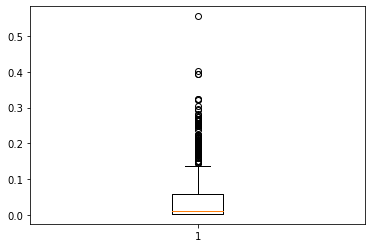

In [22]:
plt.boxplot(stima_veridicita_articoli.estimate)

<AxesSubplot:xlabel='article_id'>

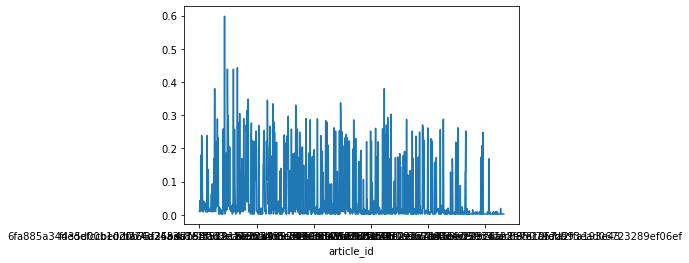

In [27]:
#AVG OF AVG

stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:
    
    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    
    if(num_cit_entranti > 0):
    
        autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values


        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()

        #calcolo la distanza tra le communities che mi citano 
        
        
        communities_coinvolte = []
        
        autori_coinvolti = autori_citanti 
        autori_coinvolti = np.append(autori_coinvolti,autore)

        
        #in questo modo insierisco anche la community dell'autore dell'articolo 
        #=> calcolo la distanza media tra tutte le communities coinvolte, quelle dell'autore citato e citante 

        for i in autori_coinvolti:
            for j in range(len(Communities_splitted)):
                if(i in Communities_splitted.loc[j]['authors'] ):
                    communities_coinvolte.append(j)

        communities_coinvolte = np.unique(communities_coinvolte) #rimuovo duplicati
        
        #len(communities_coinvolte)>=1, poiche contiene sempre la community dell'autore dell'articolo, piu quelle citanti
        
        #len(communities_coinvolte) = 1 quando la community che cita è la stessa dell'autore che ha scritto articolo
        
        if(len(communities_coinvolte)==1):
        
            stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore/PR_Max) + b*(num_cit_entranti/cit_entranti_max) + c*(AVG_PR_autori_citanti/PR_Max)
        
        else:

            Min_of_hop_avg_dist = computeAvgOfHopAvgDist(communities_coinvolte)
            
            if(Min_of_hop_avg_dist<1):
                print(Min_of_hop_avg_dist)

            stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore/PR_Max) + b*(num_cit_entranti/cit_entranti_max) + c*(AVG_PR_autori_citanti/PR_Max) + d*(Min_of_hop_avg_dist/max_len) 
    
    else:
        stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore/PR_Max)  
    
    #if(stima_veridicita_articoli.loc[m]['estimate']<0):
    #    print(Min_of_hop_avg_dist)
    #    print(min_len)
    #    print('\n')
    
stima_veridicita_articoli.estimate.plot()    



In [28]:
stima_veridicita_articoli.estimate.min()

0.00227967393505836

{'whiskers': [<matplotlib.lines.Line2D at 0x26958b82460>,
 'caps': [<matplotlib.lines.Line2D at 0x26958b82b50>,
 'boxes': [<matplotlib.lines.Line2D at 0x26958b82100>],
 'medians': [<matplotlib.lines.Line2D at 0x26958b8e250>],
 'fliers': [<matplotlib.lines.Line2D at 0x26958b8e5b0>],
 'means': []}

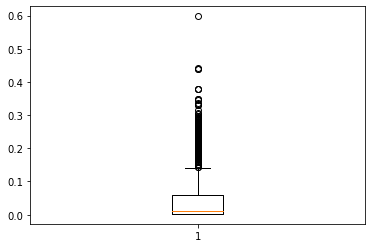

In [29]:
plt.boxplot(stima_veridicita_articoli.estimate)

# NORMALIZZAZIONE FATTA CON MINMAX DOPO IL CALCOLO COMPLETO

In [34]:
#NORMALIZZAZIONE MINMAX FATTA DOPO IL CALCOLO COMPLETO, CHE QUINDI VIENE SVOLTO SENZA NORMALIZZAZIONI

#MIN OF AVG

stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:
    
    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    
    if(num_cit_entranti > 0):
    
        autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values


        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()

        #calcolo la distanza tra le communities che mi citano 
        
        
        communities_coinvolte = []
        
        autori_coinvolti = autori_citanti 
        autori_coinvolti = np.append(autori_coinvolti,autore)

        
        #in questo modo insierisco anche la community dell'autore dell'articolo 
        #=> calcolo la distanza media tra tutte le communities coinvolte, quelle dell'autore citato e citante 

        for i in autori_coinvolti:
            for j in range(len(Communities_splitted)):
                if(i in Communities_splitted.loc[j]['authors'] ):
                    communities_coinvolte.append(j)

        communities_coinvolte = np.unique(communities_coinvolte) #rimuovo duplicati
        
        #len(communities_coinvolte)>=1, poiche contiene sempre la community dell'autore dell'articolo, piu quelle citanti
        
        #len(communities_coinvolte) = 1 quando la community che cita è la stessa dell'autore che ha scritto articolo
        
        if(len(communities_coinvolte)==1):
        
            stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore) + b*(num_cit_entranti) + c*(AVG_PR_autori_citanti) 
        
        else:

            Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_coinvolte)
            
            if(Min_of_hop_avg_dist<1):
                print(Min_of_hop_avg_dist)

            stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore) + b*(num_cit_entranti) + c*(AVG_PR_autori_citanti) + d*(Min_of_hop_avg_dist)  
    
    else:
        stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore)
    
    



    

<AxesSubplot:xlabel='article_id'>

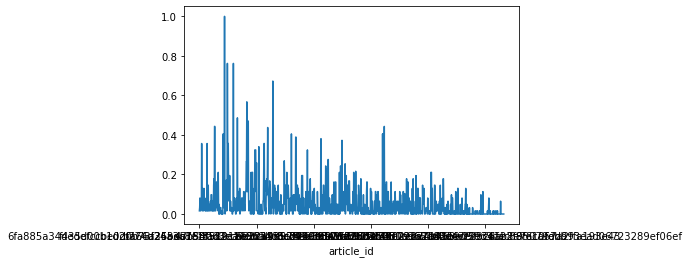

In [35]:
#X_normalized = (X - X_min) / (X_max - X_min)
min_val = stima_veridicita_articoli.estimate.min()
max_val = stima_veridicita_articoli.estimate.max()
max_minus_min = max_val - min_val

stima_veridicita_articoli['estimate'] = stima_veridicita_articoli['estimate'].apply(lambda row: (row - min_val)/max_minus_min)
stima_veridicita_articoli.estimate.plot()

In [33]:
stima_veridicita_articoli.estimate.min()

0.0

In [36]:
#NORMALIZZAZIONE MINMAX FATTA DOPO IL CALCOLO COMPLETO, CHE QUINDI VIENE SVOLTO SENZA NORMALIZZAZIONI

#AVG OF AVG

stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:
    
    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    
    if(num_cit_entranti > 0):
    
        autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values


        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()

        #calcolo la distanza tra le communities che mi citano 
        
        
        communities_coinvolte = []
        
        autori_coinvolti = autori_citanti 
        autori_coinvolti = np.append(autori_coinvolti,autore)

        
        #in questo modo insierisco anche la community dell'autore dell'articolo 
        #=> calcolo la distanza media tra tutte le communities coinvolte, quelle dell'autore citato e citante 

        for i in autori_coinvolti:
            for j in range(len(Communities_splitted)):
                if(i in Communities_splitted.loc[j]['authors'] ):
                    communities_coinvolte.append(j)

        communities_coinvolte = np.unique(communities_coinvolte) #rimuovo duplicati
        
        #len(communities_coinvolte)>=1, poiche contiene sempre la community dell'autore dell'articolo, piu quelle citanti
        
        #len(communities_coinvolte) = 1 quando la community che cita è la stessa dell'autore che ha scritto articolo
        
        if(len(communities_coinvolte)==1):
        
            stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore) + b*(num_cit_entranti) + c*(AVG_PR_autori_citanti) 
        
        else:

            Min_of_hop_avg_dist = computeAvgOfHopAvgDist(communities_coinvolte)
            
            if(Min_of_hop_avg_dist<1):
                print(Min_of_hop_avg_dist)

            stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore) + b*(num_cit_entranti) + c*(AVG_PR_autori_citanti) + d*(Min_of_hop_avg_dist)  
    
    else:
        stima_veridicita_articoli.loc[m]['estimate'] = a*(PR_autore)
    
    



    

<AxesSubplot:xlabel='article_id'>

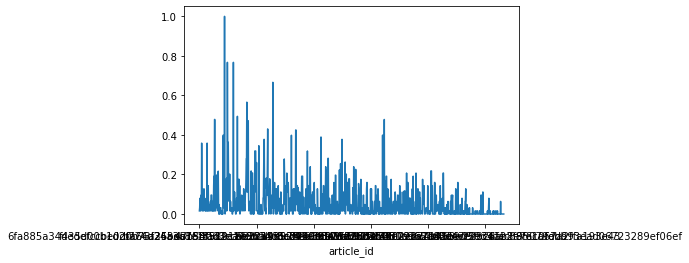

In [37]:
#X_normalized = (X - X_min) / (X_max - X_min)
min_val = stima_veridicita_articoli.estimate.min()
max_val = stima_veridicita_articoli.estimate.max()
max_minus_min = max_val - min_val

stima_veridicita_articoli['estimate'] = stima_veridicita_articoli['estimate'].apply(lambda row: (row - min_val)/max_minus_min)
stima_veridicita_articoli.estimate.plot()

In [38]:
stima_veridicita_articoli.estimate.min()

0.0

# NORMALIZZAZIONE FATTA CON MIN MAX SU OGNI VARIABILE IN BASE ALLA SUA DISTRIBUZIONE

<AxesSubplot:xlabel='article_id'>

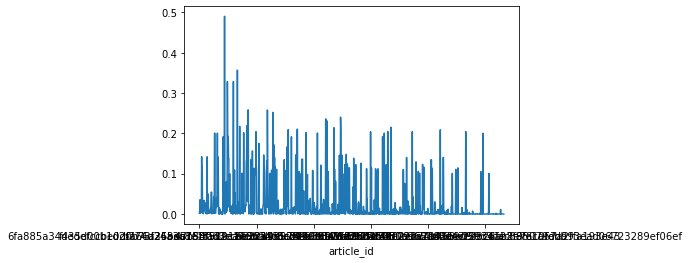

In [39]:

#X_normalized = (X - X_min) / (X_max - X_min)

#MIN OF AVG

stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    
    if(num_cit_entranti > 0):
    
        autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values


        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()

        #print(autori_citanti)

        #calcolo la distanza tra le communities che mi citano 
        
        
        communities_coinvolte = []
        
        autori_coinvolti = autori_citanti 
        autori_coinvolti = np.append(autori_coinvolti,autore)
        
        #in questo modo insierisco anche la community dell'autore dell'articolo 
        #=> calcolo la distanza media tra tutte le communities coinvolte, quelle dell'autore citato e citante 

        for i in autori_coinvolti:
            for j in range(len(Communities_splitted)):
                if(i in Communities_splitted.loc[j]['authors'] ):
                    communities_coinvolte.append(j)

        communities_coinvolte = np.unique(communities_coinvolte) #rimuovo duplicati
        #len(communities_coinvolte)>=1, poiche contiene sempre la community dell'autore dell'articolo, piu quelle citanti
        
        #len(communities_coinvolte) = 1 quando la community che cita è la stessa dell'autore che ha scritto articolo
        
        #print(communities_coinvolte)
        
        if(len(communities_coinvolte)==1):
        
            stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference)  
        
        else:

            Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_coinvolte)
            
            if(Min_of_hop_avg_dist<1):
                print(Min_of_hop_avg_dist)

            stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference) + d*((Min_of_hop_avg_dist-min_len)/len_Difference)  
    
    else:
        stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference)   

    
stima_veridicita_articoli.estimate.plot()    

In [40]:
stima_veridicita_articoli.estimate.min()

0.0

<AxesSubplot:xlabel='article_id'>

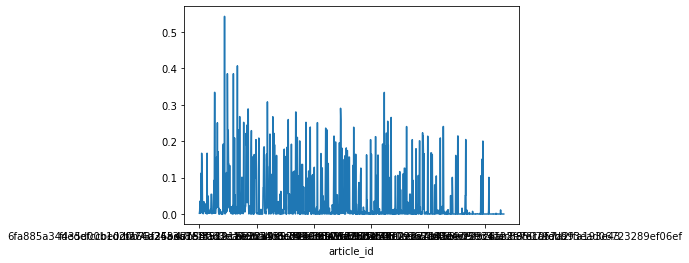

In [41]:

#AVG OF AVG


#X_normalized = (X - X_min) / (X_max - X_min)


stima = []

a = 0.2
b = 0.2
c = 0.2
d = 0.4

for m in msg_DB:

    autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
    PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
    num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])
    
    if(num_cit_entranti > 0):
    
        autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values


        AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()

        #print(autori_citanti)

        #calcolo la distanza tra le communities che mi citano 
        
        
        communities_coinvolte = []
        
        autori_coinvolti = autori_citanti 
        autori_coinvolti = np.append(autori_coinvolti,autore)
        
        #in questo modo insierisco anche la community dell'autore dell'articolo 
        #=> calcolo la distanza media tra tutte le communities coinvolte, quelle dell'autore citato e citante 

        for i in autori_coinvolti:
            for j in range(len(Communities_splitted)):
                if(i in Communities_splitted.loc[j]['authors'] ):
                    communities_coinvolte.append(j)

        communities_coinvolte = np.unique(communities_coinvolte) #rimuovo duplicati
        #len(communities_coinvolte)>=1, poiche contiene sempre la community dell'autore dell'articolo, piu quelle citanti
        
        #len(communities_coinvolte) = 1 quando la community che cita è la stessa dell'autore che ha scritto articolo
        
        #print(communities_coinvolte)
        
        if(len(communities_coinvolte)==1):
        
            stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference)  
        
        else:

            Min_of_hop_avg_dist = computeAvgOfHopAvgDist(communities_coinvolte)
            
            if(Min_of_hop_avg_dist<1):
                print(Min_of_hop_avg_dist)

            stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference) + d*((Min_of_hop_avg_dist-min_len)/len_Difference)  
    
    else:
        stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference)   

    
stima_veridicita_articoli.estimate.plot()    

In [42]:
stima_veridicita_articoli.estimate.min()

0.0

# TEST VARIANDO A,B,C,D SULLA SOLUZIONE 3 (MIN MAX SU OGNI VARIABILE)

V: 0
V: 1
V: 2
V: 3
V: 4
V: 5
V: 6
V: 7
V: 8


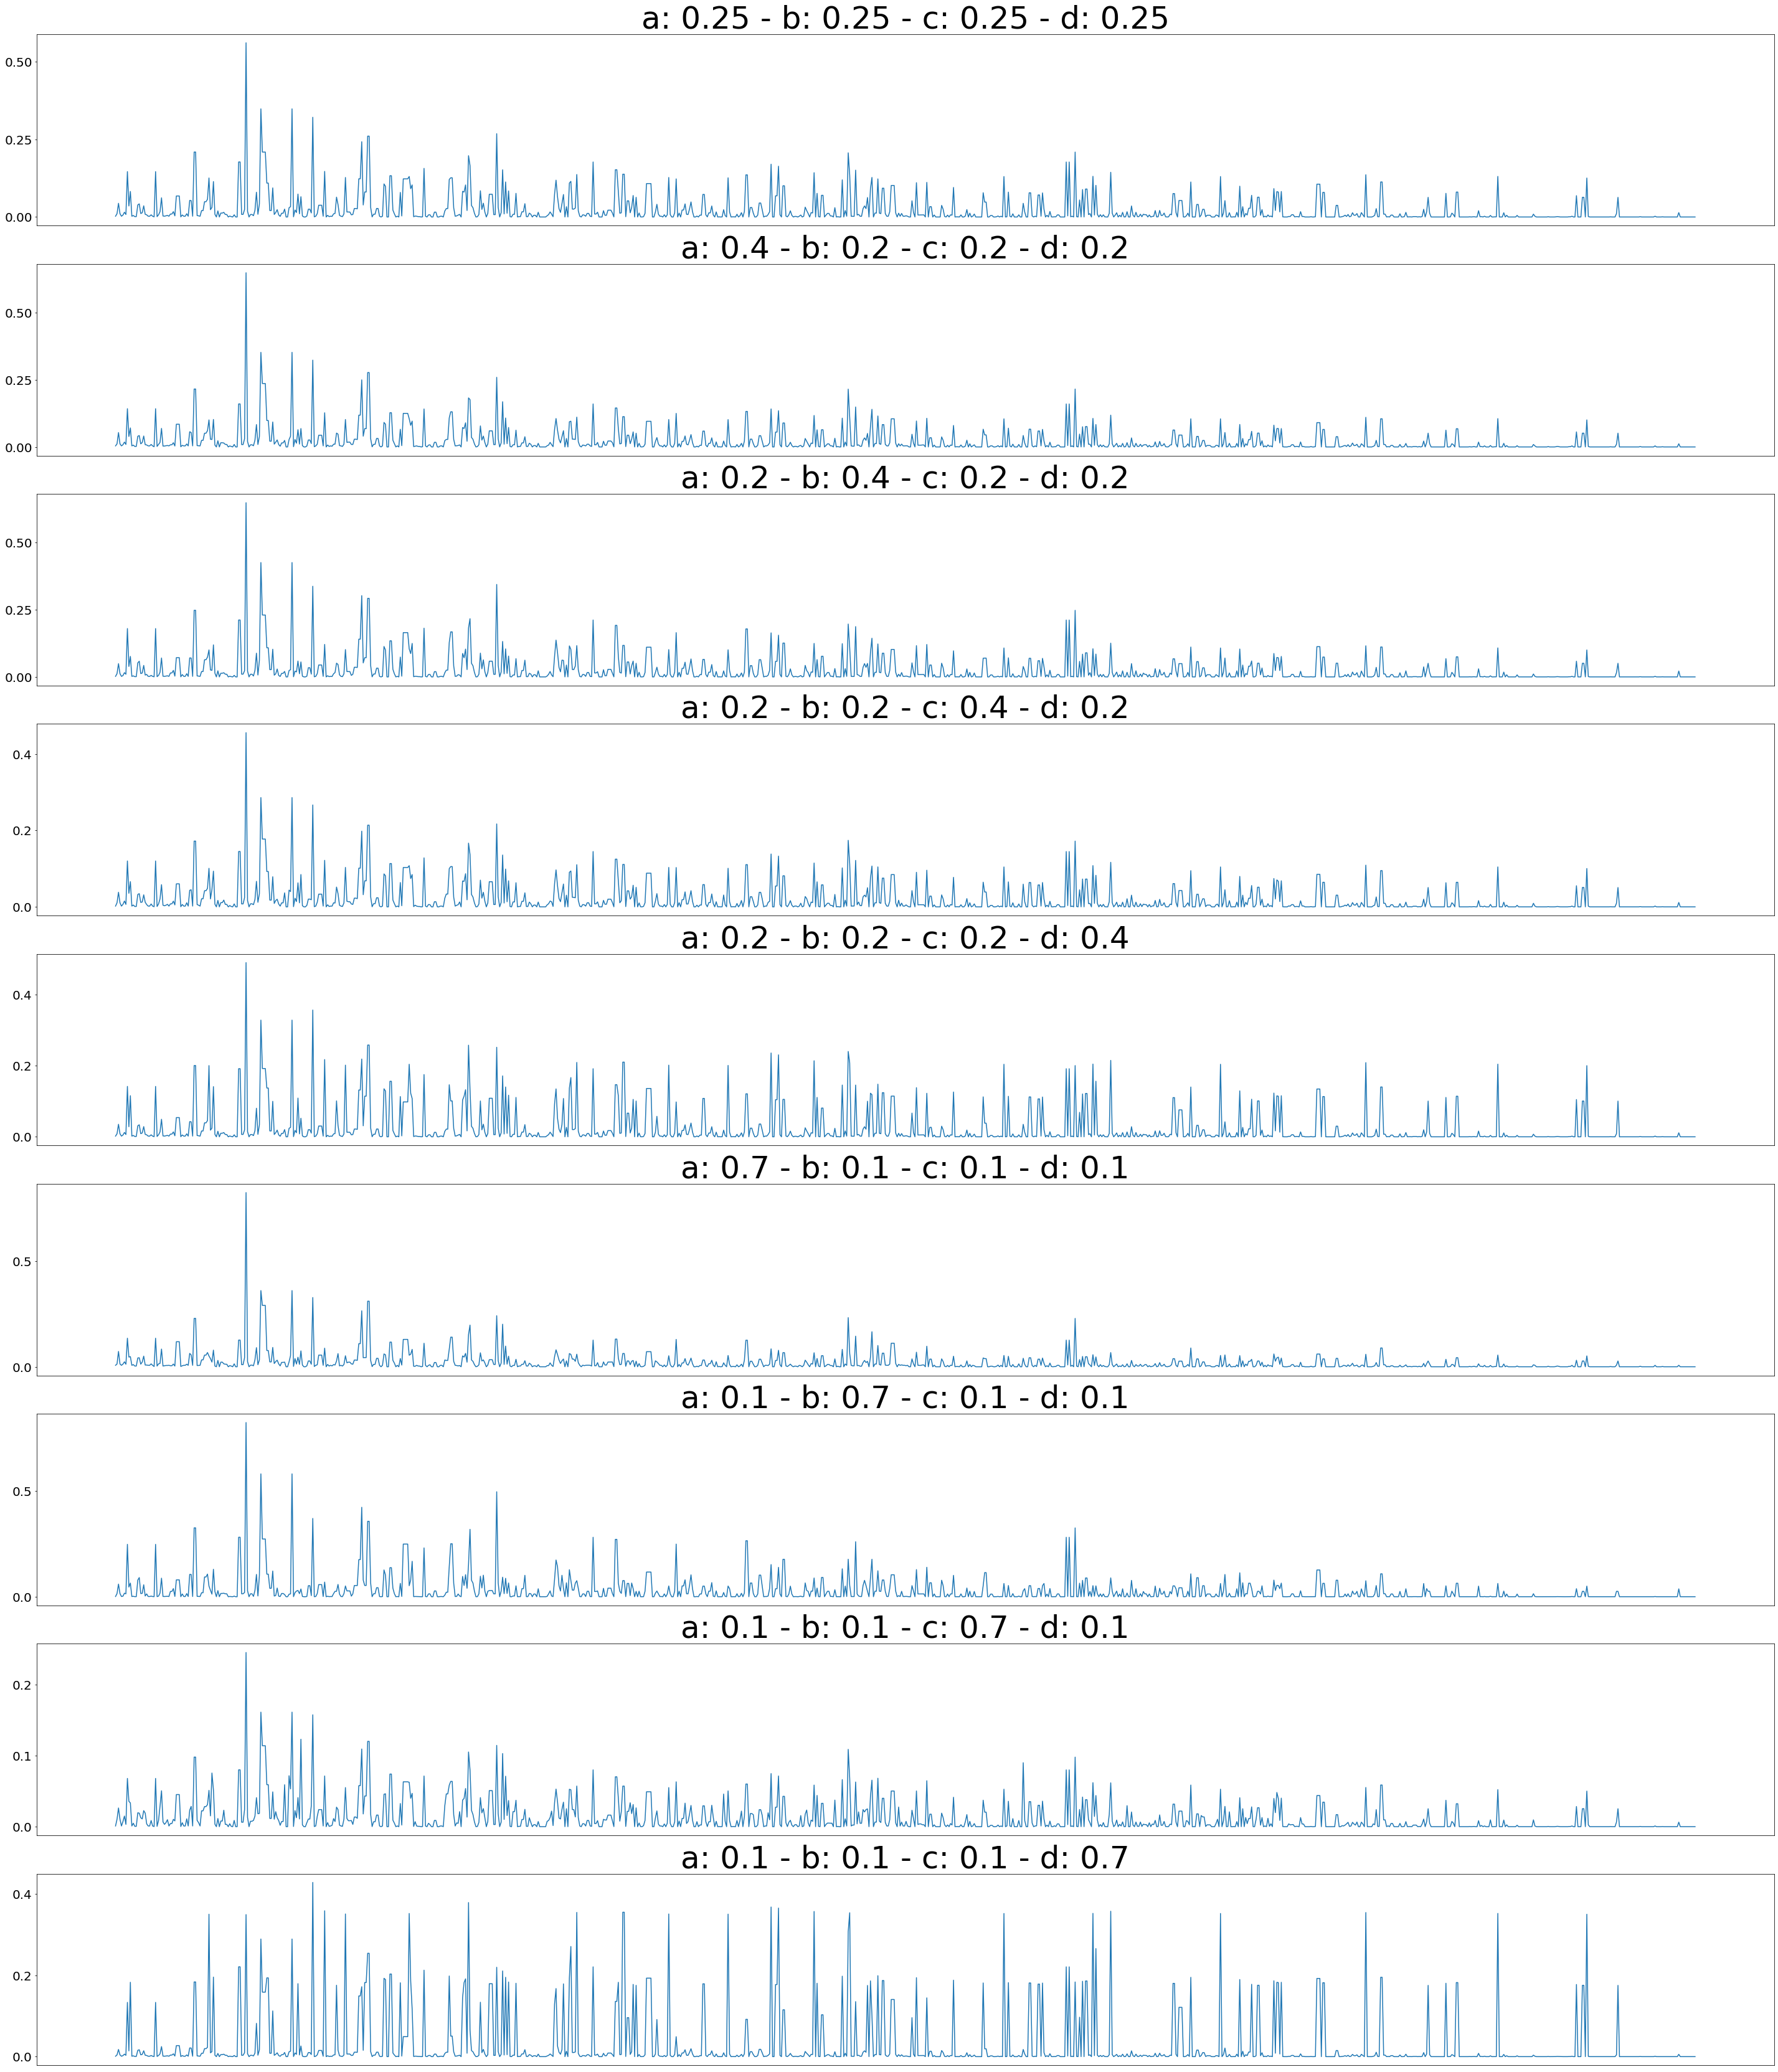

In [45]:


#MIN OF AVG

lista_df = []

stima = []

figure, axis = plt.subplots(9,1,figsize=(50, 60))


Variabili = [(0.25,0.25,0.25,0.25), (0.4,0.2,0.2,0.2), (0.2,0.4,0.2,0.2), (0.2,0.2,0.4,0.2), (0.2,0.2,0.2,0.4), 
            (0.7,0.1,0.1,0.1), (0.1,0.7,0.1,0.1), (0.1,0.1,0.7,0.1), (0.1,0.1,0.1,0.7)]

for v in range(len(Variabili)):
    print(f'V: {v}')
    valori = Variabili[v]
    
    a = valori[0]
    b = valori[1]
    c = valori[2]
    d = valori[3]


    for m in msg_DB:

        autore = DB_AA_originale[DB_AA_originale['FromNodeId']==m]['From_Author_Pub_Key'].values[0]
        PR_autore = PR_df[PR_df['Author']==autore]['PR_values'].values[0]
        num_cit_entranti = len(DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore])

        if(num_cit_entranti > 0):

            autori_citanti = DB_AA_originale[DB_AA_originale['To_Author_Pub_key']==autore]['From_Author_Pub_Key'].values


            AVG_PR_autori_citanti = PR_df[PR_df['Author'].isin(autori_citanti)]['PR_values'].values.mean()

            #print(autori_citanti)

            #calcolo la distanza tra le communities che mi citano 


            communities_coinvolte = []

            autori_coinvolti = autori_citanti 
            autori_coinvolti = np.append(autori_coinvolti,autore)

            #in questo modo insierisco anche la community dell'autore dell'articolo 
            #=> calcolo la distanza media tra tutte le communities coinvolte, quelle dell'autore citato e citante 

            for i in autori_coinvolti:
                for j in range(len(Communities_splitted)):
                    if(i in Communities_splitted.loc[j]['authors'] ):
                        communities_coinvolte.append(j)

            communities_coinvolte = np.unique(communities_coinvolte) #rimuovo duplicati
            #len(communities_coinvolte)>=1, poiche contiene sempre la community dell'autore dell'articolo, piu quelle citanti

            #len(communities_coinvolte) = 1 quando la community che cita è la stessa dell'autore che ha scritto articolo

            #print(communities_coinvolte)

            if(len(communities_coinvolte)==1):

                stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference)  

            else:

                Min_of_hop_avg_dist = computeMinOfHopAvgDist(communities_coinvolte)

                if(Min_of_hop_avg_dist<1):
                    print(Min_of_hop_avg_dist)

                stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference) + b*((num_cit_entranti-cit_entranti_min)/cit_entranti_Difference) + c*((AVG_PR_autori_citanti-PR_Min)/PR_Difference) + d*((Min_of_hop_avg_dist-min_len)/len_Difference)  

        else:
            stima_veridicita_articoli.loc[m]['estimate'] = a*((PR_autore-PR_Min)/PR_Difference)   

    
    lista_df.append(stima_veridicita_articoli.copy())
    
    title = 'a: '+str(a)+' - '+'b: '+str(b)+' - '+'c: '+str(c)+' - '+'d: '+str(d)
    axis[v].plot(stima_veridicita_articoli.estimate)
    axis[v].set_title(title,fontsize = 50)
    axis[v].get_xaxis().set_visible(False)

plt.rc('ytick', labelsize=40)
plt.show()

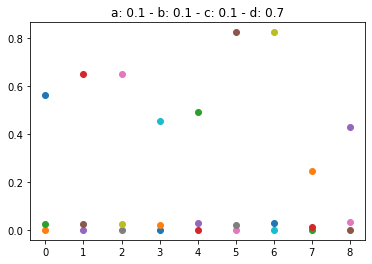

Valori: 
a: 0.25, b: 0.25, c: 0.25, d: 0.25
Valori: 
a: 0.4, b: 0.2, c: 0.2, d: 0.2
Valori: 
a: 0.2, b: 0.4, c: 0.2, d: 0.2
Valori: 
a: 0.2, b: 0.2, c: 0.4, d: 0.2
Valori: 
a: 0.2, b: 0.2, c: 0.2, d: 0.4
Valori: 
a: 0.7, b: 0.1, c: 0.1, d: 0.1
Valori: 
a: 0.1, b: 0.7, c: 0.1, d: 0.1
Valori: 
a: 0.1, b: 0.1, c: 0.7, d: 0.1
Valori: 
a: 0.1, b: 0.1, c: 0.1, d: 0.7


In [44]:
Variabili = [(0.25,0.25,0.25,0.25), (0.4,0.2,0.2,0.2), (0.2,0.4,0.2,0.2), (0.2,0.2,0.4,0.2), (0.2,0.2,0.2,0.4), 
            (0.7,0.1,0.1,0.1), (0.1,0.7,0.1,0.1), (0.1,0.1,0.7,0.1), (0.1,0.1,0.1,0.7)]


for v in range(len(Variabili)):
    
    valori = Variabili[v]
    
    a = valori[0]
    b = valori[1]
    c = valori[2]
    d = valori[3]
    
    df = lista_df[v]
    
    
    plt.scatter(v, df.estimate.max(), label = str(v))
    plt.scatter(v, df.estimate.min(), label = str(v))
    plt.scatter(v, df.estimate.mean(), label = str(v))
    
    plt.title('a: '+str(a)+' - '+'b: '+str(b)+' - '+'c: '+str(c)+' - '+'d: '+str(d))
    #axis[v].boxplot(stima_veridicita_articoli.estimate)
    #axis[v].set_title(title,fontsize = 50)
    #axis[v].get_xaxis().set_visible(False)
#plt.legend()

    #plt.rc('ytick', labelsize=40)
plt.rc('ytick', labelsize=20)
plt.show()

for v in range(len(Variabili)):
    
    valori = Variabili[v]
    
    a = valori[0]
    b = valori[1]
    c = valori[2]
    d = valori[3]
    
    df = lista_df[v]
    
    print('Valori: ')
    print(f'a: {a}, b: {b}, c: {c}, d: {d}')